# TP :  Détecteur de points d'intérêt SIFT et descripteur SIFT

#  1. Localisation d'objets avec SIFT:

In [22]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

In [27]:
def detect_objects_in_scenes(image_objects, image_scenes, ratio_thresh=0.75, min_match_count=10, score_thresh=0.06):
    # Vérification des listes d'images
    if len(image_objects) != len(image_scenes):
        print("Erreur: Le nombre d'images objets et de scènes doit être égal.")
        return

    # Initialisation du détecteur SIFT avec plus de points clés
    sift = cv2.SIFT_create(nfeatures=8000)

    # Itération sur chaque paire (image objet, image scène)
    for i, (image_object, image_scene) in enumerate(zip(image_objects, image_scenes)):
        if image_object is None or image_scene is None:
            print(f"Erreur: Impossible de charger l'image objet {i + 1} ou la scène {i + 1}.")
            continue

        # Conversion en niveaux de gris pour SIFT
        gray_object = cv2.cvtColor(image_object, cv2.COLOR_BGR2GRAY)
        gray_scene = cv2.cvtColor(image_scene, cv2.COLOR_BGR2GRAY)

        # Détection des points clés et calcul des descripteurs
        keypoints_obj, descriptors_obj = sift.detectAndCompute(gray_object, None)
        keypoints_scene, descriptors_scene = sift.detectAndCompute(gray_scene, None)

        if descriptors_obj is None or descriptors_scene is None:
            print(f"Pas assez de caractéristiques détectées dans l'image objet {i + 1} ou la scène {i + 1}.")
            continue

        # Création du matcher FLANN
        index_params = dict(algorithm=1, trees=5)
        search_params = dict(checks=50)
        flann = cv2.FlannBasedMatcher(index_params, search_params)

        # Mise en correspondance des descripteurs
        matches = flann.knnMatch(descriptors_obj, descriptors_scene, k=2)

        # Filtrage des bonnes correspondances avec le ratio test de Lowe
        good_matches = [m for m, n in matches if m.distance < ratio_thresh * n.distance]

        # Calcul du score de correspondance
        score = len(good_matches) / len(descriptors_obj) if len(descriptors_obj) > 0 else 0

        if score < score_thresh:
            print(f"Objet {i + 1} non détecté dans la scène {i + 1} (score: {score:.2f}, seuil: {score_thresh}).")
            continue

        if len(good_matches) >= min_match_count:
            # Extraction des points correspondants
            src_pts = np.float32([keypoints_obj[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
            dst_pts = np.float32([keypoints_scene[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

            # Clustering des correspondances avec DBSCAN
            clustering = DBSCAN(eps=50, min_samples=5).fit(dst_pts.reshape(-1, 2))
            labels = clustering.labels_

            # Nombre de clusters (instances de l'objet)
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

            # Pour chaque cluster, calculer l'homographie et dessiner la boîte
            for cluster_id in range(n_clusters):
                cluster_mask = (labels == cluster_id)
                cluster_src_pts = src_pts[cluster_mask]
                cluster_dst_pts = dst_pts[cluster_mask]

                if len(cluster_src_pts) >= 4:  # Au moins 4 points pour calculer l'homographie
                    M, mask = cv2.findHomography(cluster_src_pts, cluster_dst_pts, cv2.RANSAC, 5.0)
                    
                    if M is not None:
                        # Dessiner la boîte autour de l'objet détecté
                        h, w = image_object.shape[:2]
                        pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
                        dst = cv2.perspectiveTransform(pts, M)

                        image_scene = cv2.polylines(image_scene, [np.int32(dst)], True, (0, 255, 0), 3, cv2.LINE_AA)

            # Affichage du score sur l'image
            cv2.putText(image_scene, f"Score: {score:.2f}", (20, 50), cv2.FONT_HERSHEY_SIMPLEX, 
                        1, (0, 255, 0), 2, cv2.LINE_AA)

        # Affichage des correspondances en couleur
        result = cv2.drawMatches(image_object, keypoints_obj, image_scene, keypoints_scene, good_matches, None, 
                                 flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

        # Affichage avec conversion en RGB pour ne pas avoir de couleurs inversées
        plt.figure(figsize=(12, 6))
        plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
        plt.title(f"Image objet {i + 1} vs Scène {i + 1} | Score: {score:.2f} | Points clés: {len(keypoints_obj)} -> {len(keypoints_scene)}")
        plt.axis("off")
        plt.show()

In [28]:
# Chargement des images objets
object_img1 = cv2.imread('./Images/objet0.jpg')  # Essai 1 : Image objet 1 (détection de l'objet sur l'image)
object_img2 = cv2.imread('./Images/objet1.jpg')  # Essai 2 : Image objet 2 (détecter plusieurs (2) fois l'objet dans l'image)
object_img3 = cv2.imread('./Images/objet2.jpg')  # Essai 3 : Image objet 3 (détecter plusieurs (3) fois l'objet dans l'image)
object_img4 = cv2.imread('./Images/objet1.jpg')  # Essai 4 : Objet ne se trouve pas sur l'image 

# Chargement des images scènes
scene_img1 = cv2.imread('./Images/scene0.jpg')  # Scène 1
scene_img2 = cv2.imread('./Images/scene1.jpg')  # Scène 2
scene_img3 = cv2.imread('./Images/scene2.jpg')  # Scène 3
scene_img4 = cv2.imread('./Images/scene2.jpg')  # Scène 4

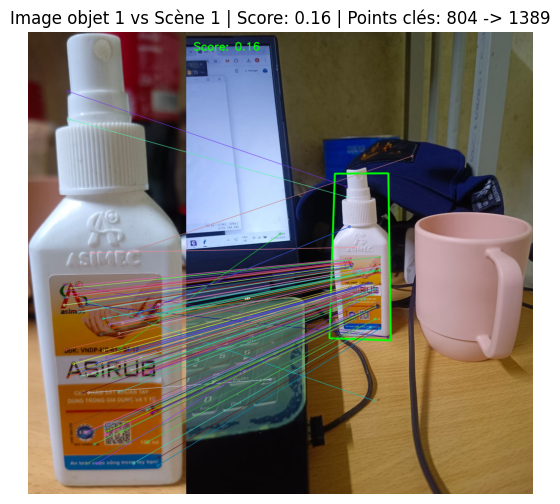

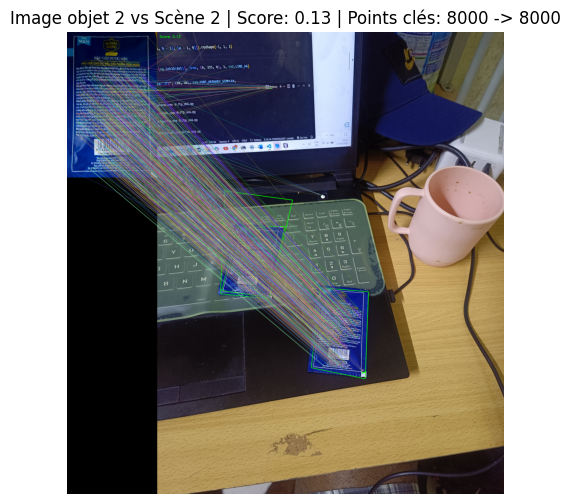

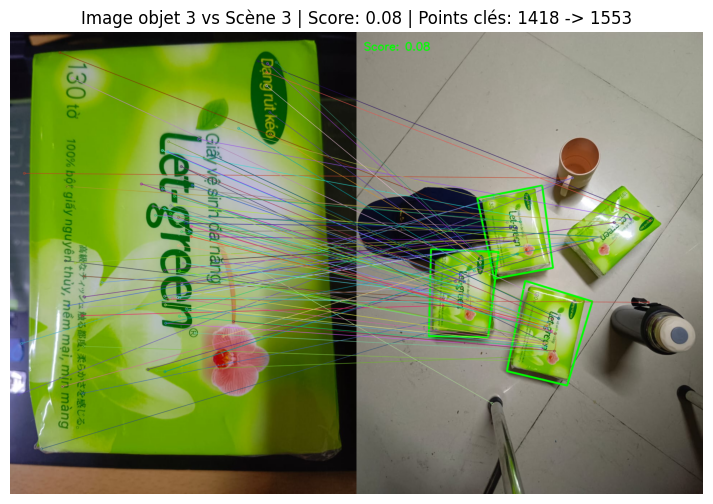

Objet 4 non détecté dans la scène 4 (score: 0.00, seuil: 0.06).


In [29]:
# Liste des images objets et des scènes
image_objects = [object_img1, object_img2, object_img3, object_img4]
image_scenes = [scene_img1, scene_img2, scene_img3, scene_img4]

# Détection des objets dans les scènes correspondantes
detect_objects_in_scenes(image_objects, image_scenes)

# 2. Reconnaissance d'objets avec SIFT

2025-03-18 22:34:12,906 - INFO - Chargement des données d'entraînement...
2025-03-18 22:34:12,908 - INFO - Chargement de la classe Agraffe...
2025-03-18 22:34:12,929 - INFO -   → 36 images chargées
2025-03-18 22:34:12,931 - INFO - Chargement de la classe Canard...
2025-03-18 22:34:12,953 - INFO -   → 36 images chargées
2025-03-18 22:34:12,954 - INFO - Chargement de la classe Canette...
2025-03-18 22:34:12,974 - INFO -   → 36 images chargées
2025-03-18 22:34:12,976 - INFO - Chargement de la classe Cigarette...
2025-03-18 22:34:12,994 - INFO -   → 36 images chargées
2025-03-18 22:34:12,996 - INFO - Chargement de la classe Grenouille...
2025-03-18 22:34:13,016 - INFO -   → 36 images chargées
2025-03-18 22:34:13,017 - INFO - Chargement de la classe Oignon...
2025-03-18 22:34:13,038 - INFO -   → 36 images chargées
2025-03-18 22:34:13,039 - INFO - Chargement de la classe Sandwich...
2025-03-18 22:34:13,058 - INFO -   → 36 images chargées
2025-03-18 22:34:13,059 - INFO - Chargement de la clas

Initialisation des détecteurs...

Chargement du dataset depuis : datasets


2025-03-18 22:34:13,105 - INFO -   → 36 images chargées
2025-03-18 22:34:13,107 - INFO - Chargement de la classe Tomate...
2025-03-18 22:34:13,134 - INFO -   → 36 images chargées
2025-03-18 22:34:13,135 - INFO - Chargement de la classe Voiture...
2025-03-18 22:34:13,156 - INFO -   → 36 images chargées
2025-03-18 22:34:13,158 - INFO - 
Chargement des données de test...
2025-03-18 22:34:13,160 - INFO - Chargement de la classe Agraffe...
2025-03-18 22:34:13,181 - INFO -   → 36 images chargées
2025-03-18 22:34:13,182 - INFO - Chargement de la classe Canard...
2025-03-18 22:34:13,203 - INFO -   → 36 images chargées
2025-03-18 22:34:13,204 - INFO - Chargement de la classe Canette...
2025-03-18 22:34:13,223 - INFO -   → 36 images chargées
2025-03-18 22:34:13,224 - INFO - Chargement de la classe Cigarette...
2025-03-18 22:34:13,243 - INFO -   → 36 images chargées
2025-03-18 22:34:13,244 - INFO - Chargement de la classe Grenouille...
2025-03-18 22:34:13,264 - INFO -   → 36 images chargées
2025-


Résumé du dataset :
Nombre total de classes : 11

Distribution des images d'entraînement :
Agraffe: 36 images
Canard: 36 images
Canette: 36 images
Cigarette: 36 images
Grenouille: 36 images
Oignon: 36 images
Sandwich: 36 images
Tasse: 36 images
Telephone: 36 images
Tomate: 36 images
Voiture: 36 images

Distribution des images de test :
Agraffe: 36 images
Canard: 36 images
Canette: 36 images
Cigarette: 36 images
Grenouille: 36 images
Oignon: 36 images
Sandwich: 36 images
Tasse: 36 images
Telephone: 36 images
Tomate: 36 images
Voiture: 36 images

Évaluation de SIFT+BF...

Résultats détaillés pour SIFT+BF:
Précision moyenne: 34.87%
Rappel moyen: 23.99%
F1-Score moyen: 16.78%

Métriques par classe:

Agraffe:
Précision: 13.64%
Rappel: 41.67%
F1-Score: 20.55%

Canard:
Précision: 100.00%
Rappel: 5.56%
F1-Score: 10.53%

Canette:
Précision: 38.10%
Rappel: 88.89%
F1-Score: 53.33%

Cigarette:
Précision: 21.28%
Rappel: 83.33%
F1-Score: 33.90%

Grenouille:
Précision: 19.23%
Rappel: 13.89%
F1-Score

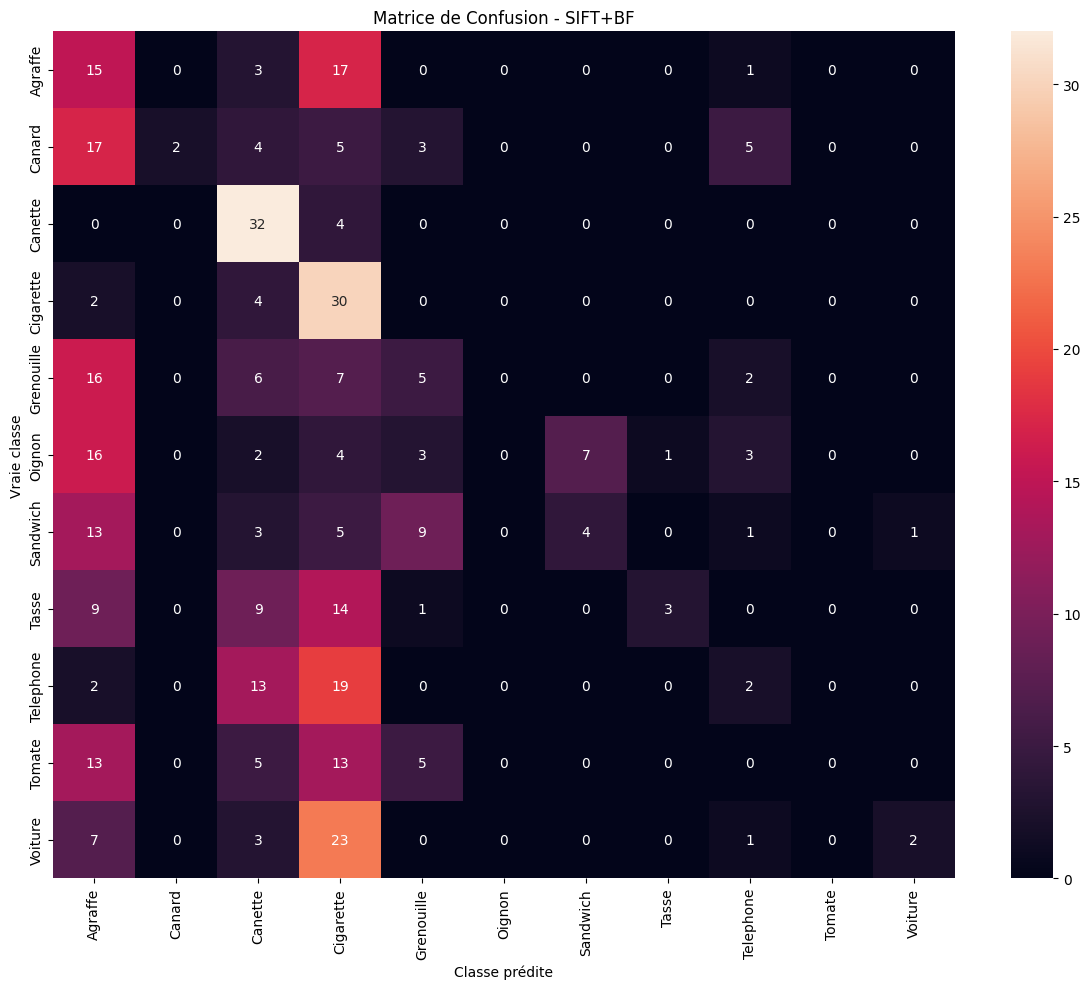


Évaluation de SIFT+FLANN...

Résultats détaillés pour SIFT+FLANN:
Précision moyenne: 62.06%
Rappel moyen: 53.46%
F1-Score moyen: 51.78%

Métriques par classe:

Agraffe:
Précision: 46.15%
Rappel: 48.00%
F1-Score: 47.06%

Canard:
Précision: 33.75%
Rappel: 81.82%
F1-Score: 47.79%

Canette:
Précision: 90.00%
Rappel: 100.00%
F1-Score: 94.74%

Cigarette:
Précision: 29.09%
Rappel: 88.89%
F1-Score: 43.84%

Grenouille:
Précision: 77.78%
Rappel: 28.00%
F1-Score: 41.18%

Oignon:
Précision: 55.00%
Rappel: 31.43%
F1-Score: 40.00%

Sandwich:
Précision: 66.67%
Rappel: 22.22%
F1-Score: 33.33%

Tasse:
Précision: 85.00%
Rappel: 73.91%
F1-Score: 79.07%

Telephone:
Précision: 55.56%
Rappel: 41.67%
F1-Score: 47.62%

Tomate:
Précision: 63.64%
Rappel: 24.14%
F1-Score: 35.00%

Voiture:
Précision: 80.00%
Rappel: 48.00%
F1-Score: 60.00%


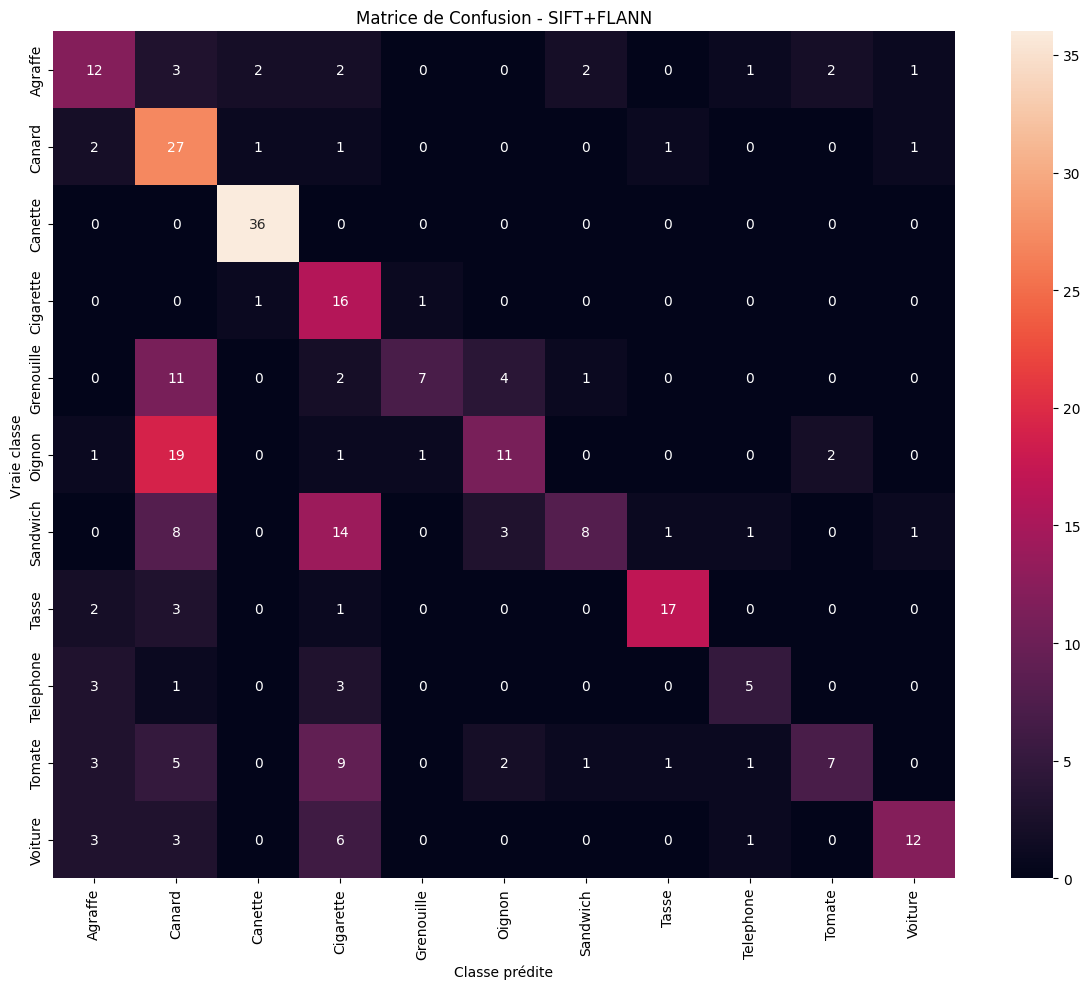


Évaluation de KAZE+BF...

Résultats détaillés pour KAZE+BF:
Précision moyenne: 41.34%
Rappel moyen: 34.09%
F1-Score moyen: 32.01%

Métriques par classe:

Agraffe:
Précision: 15.44%
Rappel: 58.33%
F1-Score: 24.42%

Canard:
Précision: 50.00%
Rappel: 16.67%
F1-Score: 25.00%

Canette:
Précision: 92.31%
Rappel: 66.67%
F1-Score: 77.42%

Cigarette:
Précision: 23.75%
Rappel: 52.78%
F1-Score: 32.76%

Grenouille:
Précision: 50.00%
Rappel: 13.89%
F1-Score: 21.74%

Oignon:
Précision: 0.00%
Rappel: 0.00%
F1-Score: 0.00%

Sandwich:
Précision: 65.52%
Rappel: 52.78%
F1-Score: 58.46%

Tasse:
Précision: 87.50%
Rappel: 19.44%
F1-Score: 31.82%

Telephone:
Précision: 22.22%
Rappel: 27.78%
F1-Score: 24.69%

Tomate:
Précision: 0.00%
Rappel: 0.00%
F1-Score: 0.00%

Voiture:
Précision: 48.00%
Rappel: 66.67%
F1-Score: 55.81%


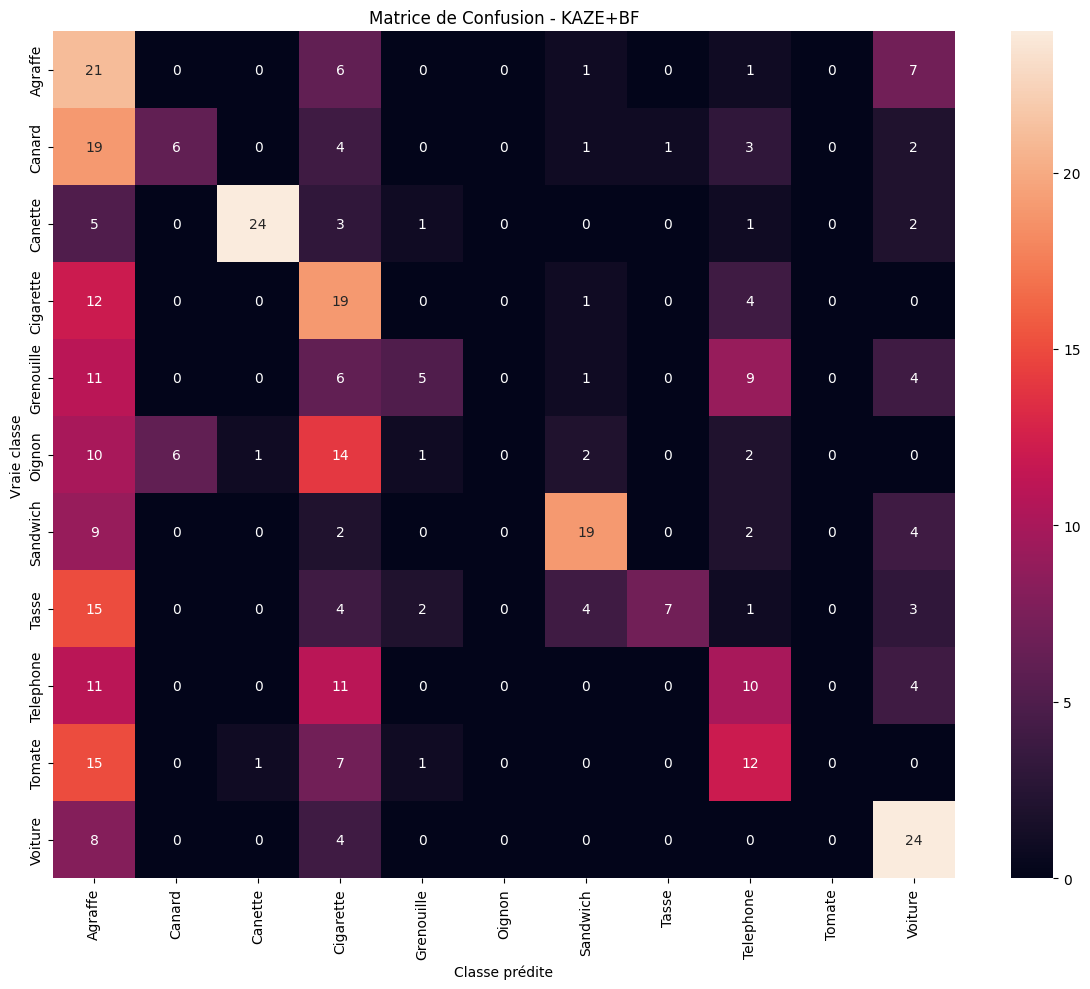


Évaluation de KAZE+FLANN...

Résultats détaillés pour KAZE+FLANN:
Précision moyenne: 62.10%
Rappel moyen: 56.98%
F1-Score moyen: 56.03%

Métriques par classe:

Agraffe:
Précision: 57.14%
Rappel: 44.44%
F1-Score: 50.00%

Canard:
Précision: 63.16%
Rappel: 36.36%
F1-Score: 46.15%

Canette:
Précision: 55.38%
Rappel: 100.00%
F1-Score: 71.29%

Cigarette:
Précision: 35.29%
Rappel: 54.55%
F1-Score: 42.86%

Grenouille:
Précision: 100.00%
Rappel: 33.33%
F1-Score: 50.00%

Oignon:
Précision: 54.55%
Rappel: 50.00%
F1-Score: 52.17%

Sandwich:
Précision: 84.85%
Rappel: 82.35%
F1-Score: 83.58%

Tasse:
Précision: 71.88%
Rappel: 76.67%
F1-Score: 74.19%

Telephone:
Précision: 45.45%
Rappel: 26.32%
F1-Score: 33.33%

Tomate:
Précision: 73.33%
Rappel: 50.00%
F1-Score: 59.46%

Voiture:
Précision: 42.11%
Rappel: 72.73%
F1-Score: 53.33%


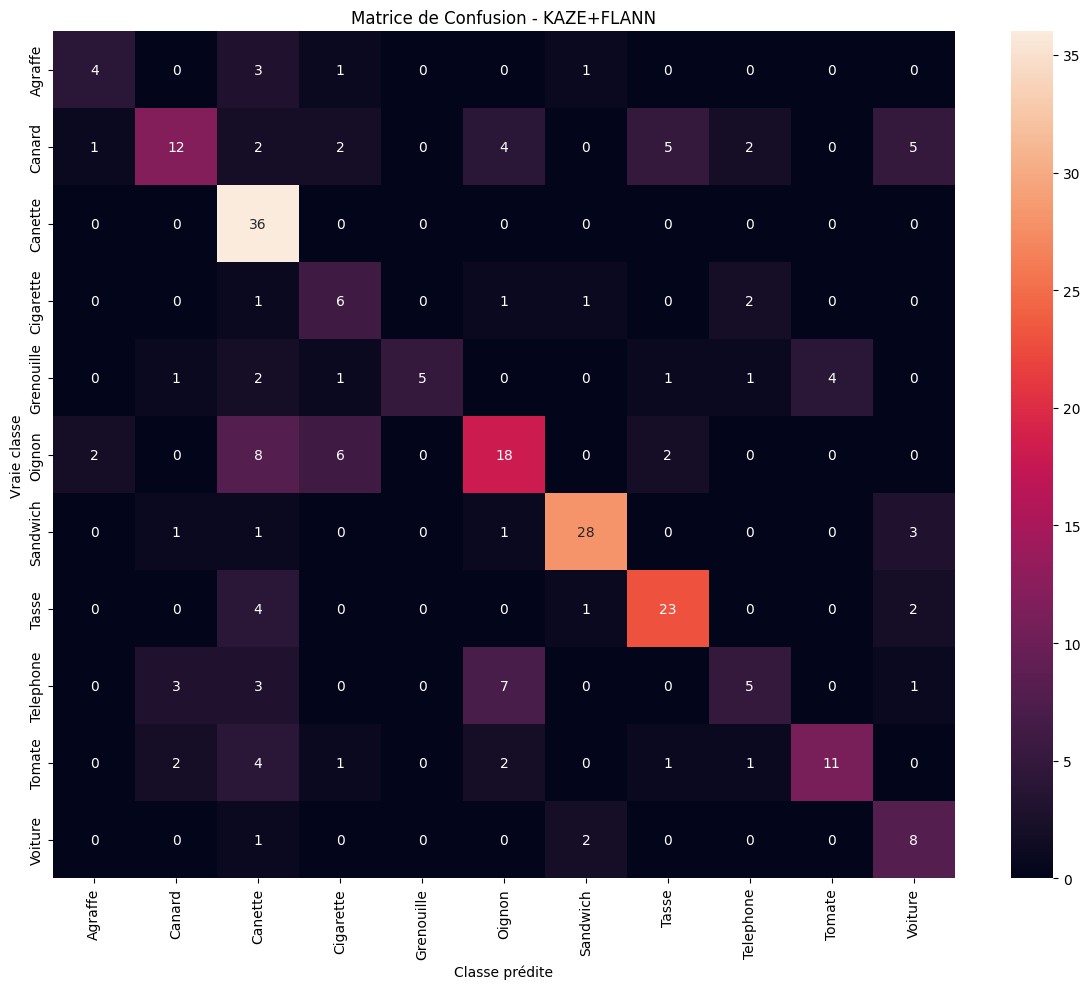


Évaluation de ORB+BF...

Résultats détaillés pour ORB+BF:
Précision moyenne: 26.29%
Rappel moyen: 15.16%
F1-Score moyen: 9.36%

Métriques par classe:

Agraffe:
Précision: 5.56%
Rappel: 8.33%
F1-Score: 6.67%

Canard:
Précision: 33.33%
Rappel: 3.12%
F1-Score: 5.71%

Canette:
Précision: 11.70%
Rappel: 30.56%
F1-Score: 16.92%

Cigarette:
Précision: 18.56%
Rappel: 100.00%
F1-Score: 31.30%

Grenouille:
Précision: 50.00%
Rappel: 8.33%
F1-Score: 14.29%

Oignon:
Précision: 0.00%
Rappel: 0.00%
F1-Score: 0.00%

Sandwich:
Précision: 100.00%
Rappel: 2.86%
F1-Score: 5.56%

Tasse:
Précision: 33.33%
Rappel: 8.00%
F1-Score: 12.90%

Telephone:
Précision: 20.00%
Rappel: 2.78%
F1-Score: 4.88%

Tomate:
Précision: 0.00%
Rappel: 0.00%
F1-Score: 0.00%

Voiture:
Précision: 16.67%
Rappel: 2.78%
F1-Score: 4.76%


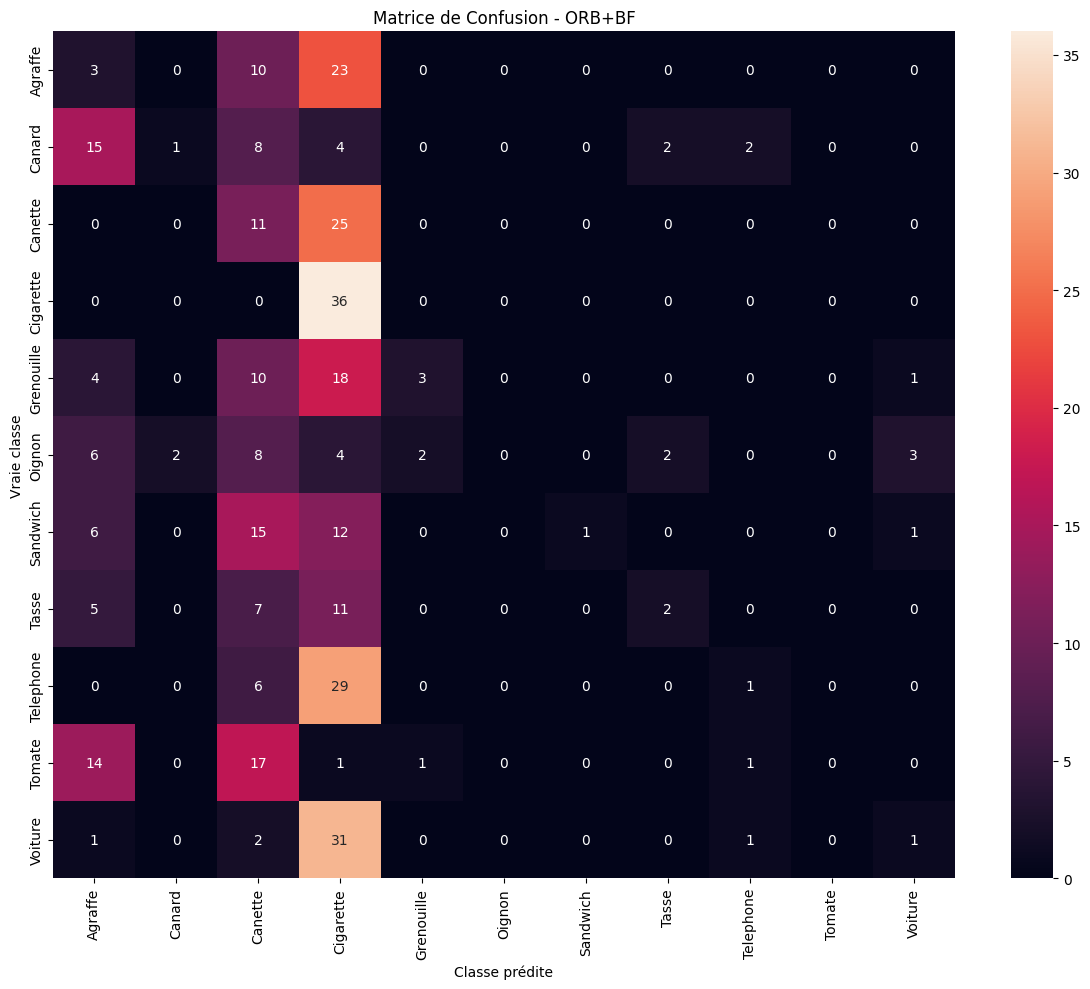


Évaluation de AKAZE+BF...

Résultats détaillés pour AKAZE+BF:
Précision moyenne: 22.90%
Rappel moyen: 15.68%
F1-Score moyen: 10.80%

Métriques par classe:

Agraffe:
Précision: 14.58%
Rappel: 38.89%
F1-Score: 21.21%

Canard:
Précision: 100.00%
Rappel: 19.23%
F1-Score: 32.26%

Canette:
Précision: 50.00%
Rappel: 8.70%
F1-Score: 14.81%

Cigarette:
Précision: 19.10%
Rappel: 94.44%
F1-Score: 31.78%

Grenouille:
Précision: 0.00%
Rappel: 0.00%
F1-Score: 0.00%

Oignon:
Précision: 0.00%
Rappel: 0.00%
F1-Score: 0.00%

Sandwich:
Précision: 25.00%
Rappel: 2.94%
F1-Score: 5.26%

Tasse:
Précision: 0.00%
Rappel: 0.00%
F1-Score: 0.00%

Telephone:
Précision: 18.18%
Rappel: 5.56%
F1-Score: 8.51%

Tomate:
Précision: 0.00%
Rappel: 0.00%
F1-Score: 0.00%

Voiture:
Précision: 25.00%
Rappel: 2.78%
F1-Score: 5.00%


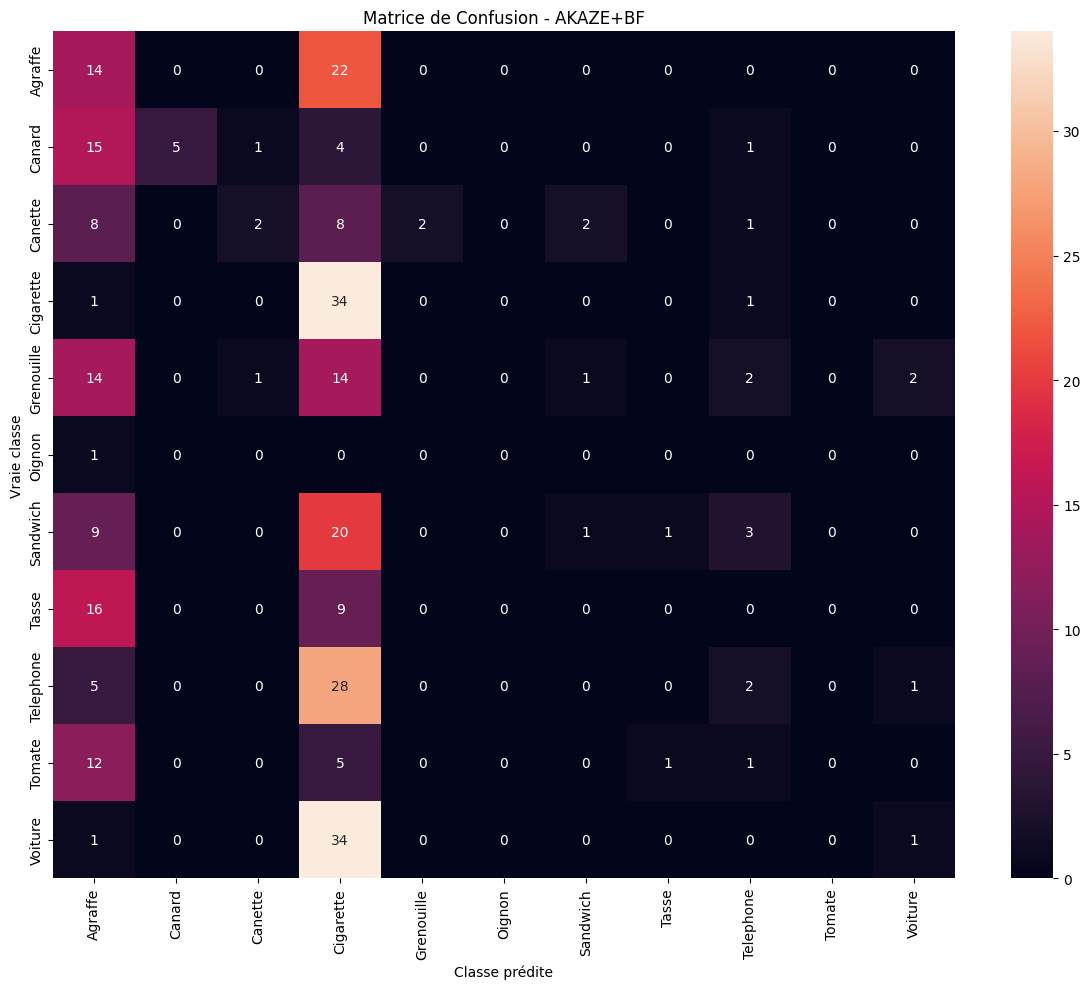


Comparaison finale des performances:

SIFT+BF:
Précision moyenne: 34.87%
Rappel moyen: 23.99%
F1-Score moyen: 16.78%

SIFT+FLANN:
Précision moyenne: 62.06%
Rappel moyen: 53.46%
F1-Score moyen: 51.78%

KAZE+BF:
Précision moyenne: 41.34%
Rappel moyen: 34.09%
F1-Score moyen: 32.01%

KAZE+FLANN:
Précision moyenne: 62.10%
Rappel moyen: 56.98%
F1-Score moyen: 56.03%

ORB+BF:
Précision moyenne: 26.29%
Rappel moyen: 15.16%
F1-Score moyen: 9.36%

AKAZE+BF:
Précision moyenne: 22.90%
Rappel moyen: 15.68%
F1-Score moyen: 10.80%


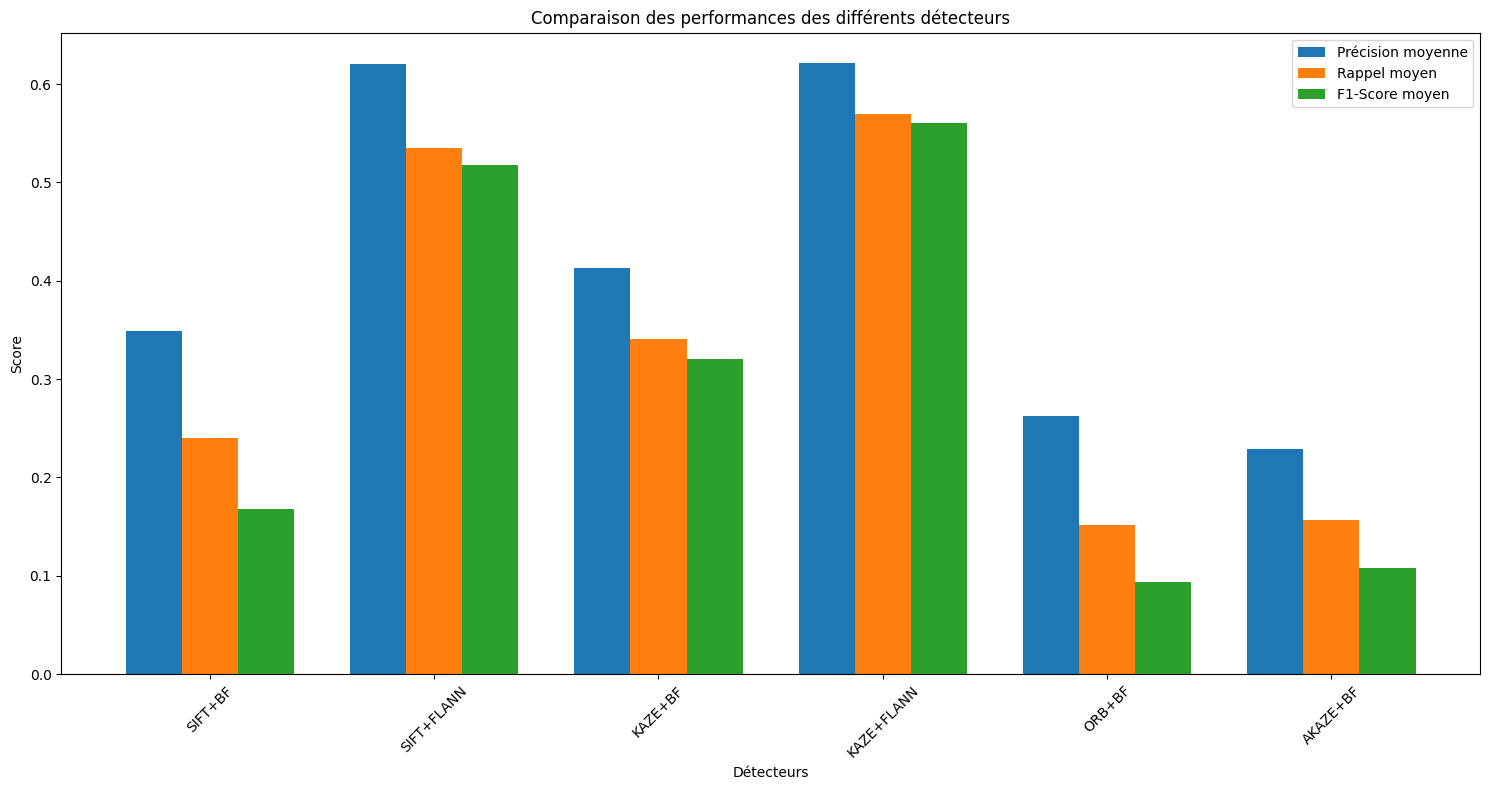

In [52]:
import cv2
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

class FeatureDetectorMatcher:
    def __init__(self, detector_type="SIFT", matcher_type="BF"):
        self.detector_type = detector_type
        self.matcher_type = matcher_type
        
        # Initialisation des détecteurs
        if detector_type == "SIFT":
            self.detector = cv2.SIFT_create()
        elif detector_type == "KAZE":
            self.detector = cv2.KAZE_create()
        elif detector_type == "ORB":
            self.detector = cv2.ORB_create()
        elif detector_type == "AKAZE":
            self.detector = cv2.AKAZE_create()
        
        # Initialisation des matchers
        if matcher_type == "BF":
            if detector_type in ["ORB", "BRISK"]:
                self.matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
            else:
                self.matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
        elif matcher_type == "FLANN":
            if detector_type in ["ORB", "BRISK"]:
                FLANN_INDEX_LSH = 6
                index_params = dict(algorithm=FLANN_INDEX_LSH,
                                  table_number=6,
                                  key_size=12,
                                  multi_probe_level=1)
            else:
                FLANN_INDEX_KDTREE = 1
                index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
            search_params = dict(checks=50)
            self.matcher = cv2.FlannBasedMatcher(index_params, search_params)

        self.ratio_thresh = 0.75
        self.min_match_count = 10
        self.score_threshold = 0.1

    def extract_features(self, image):
        if image is None:
            return None, None
        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            gray = image
        
        try:
            keypoints, descriptors = self.detector.detectAndCompute(gray, None)
            return keypoints, descriptors
        except:
            return None, None

    def match_features(self, desc1, desc2):
        if desc1 is None or desc2 is None:
            return []
        
        try:
            if self.matcher_type == "BF":
                matches = self.matcher.match(desc1, desc2)
                # Filtrage des matches par distance
                matches = sorted(matches, key=lambda x: x.distance)
                good_matches = matches[:int(len(matches) * self.ratio_thresh)]
            else:  # FLANN
                matches = self.matcher.knnMatch(desc1, desc2, k=2)
                good_matches = []
                for m, n in matches:
                    if m.distance < self.ratio_thresh * n.distance:
                        good_matches.append(m)
            return good_matches
        except:
            return []

class MultiDetectorRecognizer:
    def __init__(self):
        self.detectors = {
            "SIFT+BF": FeatureDetectorMatcher("SIFT", "BF"),
            "SIFT+FLANN": FeatureDetectorMatcher("SIFT", "FLANN"),
            "KAZE+BF": FeatureDetectorMatcher("KAZE", "BF"),
            "KAZE+FLANN": FeatureDetectorMatcher("KAZE", "FLANN"),
            "ORB+BF": FeatureDetectorMatcher("ORB", "BF"),
            "AKAZE+BF": FeatureDetectorMatcher("AKAZE", "BF")
        }

    def recognize_object(self, query_image, reference_images, detector_name):
        detector = self.detectors[detector_name]
        best_score = 0
        best_class = "unknown"
        scores = {}

        kp_query, des_query = detector.extract_features(query_image)
        
        if des_query is None:
            return best_class, scores

        for class_name, ref_image in reference_images.items():
            kp_ref, des_ref = detector.extract_features(ref_image)
            
            if des_ref is None:
                scores[class_name] = 0
                continue

            good_matches = detector.match_features(des_query, des_ref)
            
            score = len(good_matches) / len(kp_query) if len(kp_query) > 0 else 0
            scores[class_name] = score
            
            if score > best_score and score > detector.score_threshold:
                best_score = score
                best_class = class_name

        return best_class, scores

def evaluate_all_detectors(multi_detector, train_data, test_data, classes):
    results = {}
    
    reference_images = {c: train_data[c][0] for c in classes if c in train_data and train_data[c]}

    for detector_name in multi_detector.detectors.keys():
        print(f"\nÉvaluation de {detector_name}...")
        y_true = []
        y_pred = []
        
        for true_class in classes:
            if true_class not in test_data:
                continue
                
            for test_image in test_data[true_class]:
                predicted_class, _ = multi_detector.recognize_object(test_image, reference_images, detector_name)
                y_true.append(true_class)
                y_pred.append(predicted_class)

        # Calcul des métriques
        conf_matrix = confusion_matrix(y_true, y_pred, labels=classes)
        accuracy = np.sum(np.diagonal(conf_matrix)) / np.sum(conf_matrix)
        
        # Calcul de la précision et du rappel pour chaque classe
        precision_per_class = {}
        recall_per_class = {}
        f1_per_class = {}
        
        for i, classe in enumerate(classes):
            # Précision
            if np.sum(conf_matrix[:, i]) > 0:
                precision = conf_matrix[i, i] / np.sum(conf_matrix[:, i])
            else:
                precision = 0
                
            # Rappel
            if np.sum(conf_matrix[i, :]) > 0:
                recall = conf_matrix[i, i] / np.sum(conf_matrix[i, :])
            else:
                recall = 0
                
            # F1-score
            if precision + recall > 0:
                f1 = 2 * (precision * recall) / (precision + recall)
            else:
                f1 = 0
                
            precision_per_class[classe] = precision
            recall_per_class[classe] = recall
            f1_per_class[classe] = f1

        # Moyennes globales
        avg_precision = np.mean(list(precision_per_class.values()))
        avg_recall = np.mean(list(recall_per_class.values()))
        avg_f1 = np.mean(list(f1_per_class.values()))
        
        results[detector_name] = {
            'accuracy': accuracy,
            'confusion_matrix': conf_matrix,
            'precision_per_class': precision_per_class,
            'recall_per_class': recall_per_class,
            'f1_per_class': f1_per_class,
            'avg_precision': avg_precision,
            'avg_recall': avg_recall,
            'avg_f1': avg_f1
        }

        # Affichage des résultats
        print(f"\nRésultats détaillés pour {detector_name}:")
        print(f"Précision moyenne: {avg_precision:.2%}")
        print(f"Rappel moyen: {avg_recall:.2%}")
        print(f"F1-Score moyen: {avg_f1:.2%}")
        
        print("\nMétriques par classe:")
        for classe in classes:
            print(f"\n{classe}:")
            print(f"Précision: {precision_per_class[classe]:.2%}")
            print(f"Rappel: {recall_per_class[classe]:.2%}")
            print(f"F1-Score: {f1_per_class[classe]:.2%}")

        # Affichage de la matrice de confusion
        plt.figure(figsize=(12, 10))
        sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
        plt.title(f'Matrice de Confusion - {detector_name}')
        plt.ylabel('Vraie classe')
        plt.xlabel('Classe prédite')
        plt.tight_layout()
        plt.show()

    # Comparaison finale des détecteurs
    print("\nComparaison finale des performances:")
    for detector_name, result in results.items():
        print(f"\n{detector_name}:")
        print(f"Précision moyenne: {result['avg_precision']:.2%}")
        print(f"Rappel moyen: {result['avg_recall']:.2%}")
        print(f"F1-Score moyen: {result['avg_f1']:.2%}")

    return results

def visualize_comparative_results(results):
    # Préparation des données pour la visualisation
    detectors = list(results.keys())
    metrics = ['avg_precision', 'avg_recall', 'avg_f1']
    metric_labels = ['Précision moyenne', 'Rappel moyen', 'F1-Score moyen']
    
    x = np.arange(len(detectors))
    width = 0.25
    
    plt.figure(figsize=(15, 8))
    
    # Création des barres pour chaque métrique
    for i, (metric, label) in enumerate(zip(metrics, metric_labels)):
        values = [results[d][metric] for d in detectors]
        plt.bar(x + i*width, values, width, label=label)
    
    plt.xlabel('Détecteurs')
    plt.ylabel('Score')
    plt.title('Comparaison des performances des différents détecteurs')
    plt.xticks(x + width, detectors, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

def main():
    print("Initialisation des détecteurs...")
    multi_detector = MultiDetectorRecognizer()

    dataset_path = 'datasets'
    print(f"\nChargement du dataset depuis : {dataset_path}")
    train_data, test_data, classes = load_dataset(dataset_path)

    print("\nRésumé du dataset :")
    print(f"Nombre total de classes : {len(classes)}")
    print("\nDistribution des images d'entraînement :")
    for c in classes:
        if c in train_data:
            print(f"{c}: {len(train_data[c])} images")
    
    print("\nDistribution des images de test :")
    for c in classes:
        if c in test_data:
            print(f"{c}: {len(test_data[c])} images")

    results = evaluate_all_detectors(multi_detector, train_data, test_data, classes)
    
    # Visualisation comparative des résultats
    visualize_comparative_results(results)

if __name__ == "__main__":
    main()